In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cmocean.cm as cmo
import cmocean
import textwrap
import metpy.calc as mpcalc
from metpy.units import units
import seaborn as sns

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds, select_months_df
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmap
import composite_funcs as cfunc


ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
# import configuration file for case study choice
yaml_doc = '../data/domains.yml'
d = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

In [4]:
##################################
### LOAD HORIZONTAL COMPOSITES ###
##################################
## iterate through options
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']
varname_lst = ['700z', 'ivt']
# ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ssn_lst = ['NDJFMA', 'MJJASO']
ext = [-140., -90., 20, 50]
ds_lst3 = []
for h, region in enumerate(region_lst):  
    tmp_lst = []
    for i, varname in enumerate(varname_lst):  
        ds_hc_lst = []
        for j, ssn in enumerate(ssn_lst):
            ## load non-anomaly composite data
            path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
            fname = path + '{0}/{2}/composite_{0}_{1}.nc'.format(varname, ssn, region)
        
            ds = xr.open_dataset(fname)
            ds = ds.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
            ds_hc_lst.append(ds)
    
        ## concat ds_lst along ssn
        tmp = xr.concat(ds_hc_lst, pd.Index(ssn_lst, name="ssn"))
        tmp_lst.append(tmp)
    
    ## merge two datasets
    ds3 = xr.merge(tmp_lst)
    ds_lst3.append(ds3)

ds_hc = xr.concat(ds_lst3, pd.Index(region_lst, name="region"))
ds_hc

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, region: 3, ssn: 2)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * ssn        (ssn) object 'NDJFMA' 'MJJASO'
  * region     (region) object 'baja' 'san_juan' 'gulf_of_mexico'
Data variables:
    z          (region, ssn, latitude, longitude) float32 2.883e+04 ... 3.11e+04
    ivtv       (region, ssn, latitude, longitude) float32 -8.766 ... 80.65
    ivtu       (region, ssn, latitude, longitude) float32 82.26 81.59 ... -251.5
    ivt        (region, ssn, latitude, longitude) float32 152.4 152.3 ... 296.0

In [5]:
################################
### LOAD VERTICAL COMPOSITES ###
################################
## iterate through options
varname = 'uvwq'
region_lst = ['baja', 'baja2', 'san_juan2', 'san_juan', 'gulf_of_mexico', 'gulf_of_mexico2']
# ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ssn_lst = ['NDJFMA', 'MJJASO']
ext = [-140., -90., 20, 50]

ds_lst = []
ds_lst2 = []
df_lst = []
for i, region in enumerate(region_lst):  
    tmp_lst = []
    tmp_lst2 = []
    tmp_lst3 = []

    ## load dataframe for trajectory frequency
    fname = '../out/line_dates_{0}_full.csv'.format(region)
    df = pd.read_csv(fname)
    df = df.set_index(pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S'))
    df_lst.append(df)
    for j, ssn in enumerate(ssn_lst):
        ## load non-anomaly vertical composite data (uvwq)
        path = '/home/dnash/DATA/preprocessed/ERA5_composites/cross_section/'
        fname = path + 'composite_{0}_{1}_{2}.nc'.format(varname, ssn, region)
        ds = xr.open_dataset(fname)
        tmp_lst.append(ds)
        
        ## load non-anomaly vertical composite data (sp and freezing level)
        fname = path + 'composite_{0}_{1}_{2}.nc'.format('sp_deg0l', ssn, region)
        ds = xr.open_dataset(fname)
        tmp_lst2.append(ds)

    ## concat tmp_lst along ssn (uvwq)
    tmp = xr.concat(tmp_lst, pd.Index(ssn_lst, name="ssn"))

    ## add wvflux data to dataset
    qu = tmp.q*tmp.u
    qv = tmp.q*tmp.v
    tmp = tmp.assign(wvflux=np.sqrt(qu**2 + qv**2))
    if (region == 'san_juan') | (region == 'san_juan2'):
        tmp = tmp.isel(location=slice(0, -12))
    ds_lst.append(tmp)
    
        

    ##  concat tmp_lst2 along ssn (sp & freezing level)
    tmp = xr.concat(tmp_lst2, pd.Index(ssn_lst, name="ssn"))
    if (region == 'san_juan') | (region == 'san_juan2'):
        tmp = tmp.isel(location=slice(0, -12))
    ds_lst2.append(tmp)



In [6]:
ds_lst[0]

<xarray.Dataset>
Dimensions:    (location: 17, level: 23, ssn: 2)
Coordinates:
    longitude  (location) float32 -118.0 -117.5 -117.0 ... -111.0 -110.5 -110.0
    latitude   (location) float32 33.0 32.75 32.5 32.25 ... 29.5 29.25 29.0
  * level      (level) int32 1000 975 950 925 900 875 ... 350 300 250 225 200
  * ssn        (ssn) object 'NDJFMA' 'MJJASO'
Dimensions without coordinates: location
Data variables:
    q          (ssn, level, location) float32 0.007478 0.007509 ... 3.395e-05
    u          (ssn, level, location) float32 2.965 2.711 1.255 ... 18.31 17.66
    v          (ssn, level, location) float32 1.247 1.88 1.587 ... 6.883 6.287
    w          (ssn, level, location) float32 -0.01236 -0.008787 ... -0.02009

In [6]:
def plot_horizontal_composite(fig, ax, ds, cbax):    
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds.ivtu.values
    vvec = ds.ivtv.values
    # uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(0, 1280, 4)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
        txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

    # quiver key
    qk = ax.quiverkey(Q, 0.75, 1.05, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 6.0})
    
    # Colorbar (single)
    cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
    cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
    cb.ax.tick_params(labelsize=12)

    return ax

302.93454 318.08795
303.31876 318.13824
305.86847 319.0346


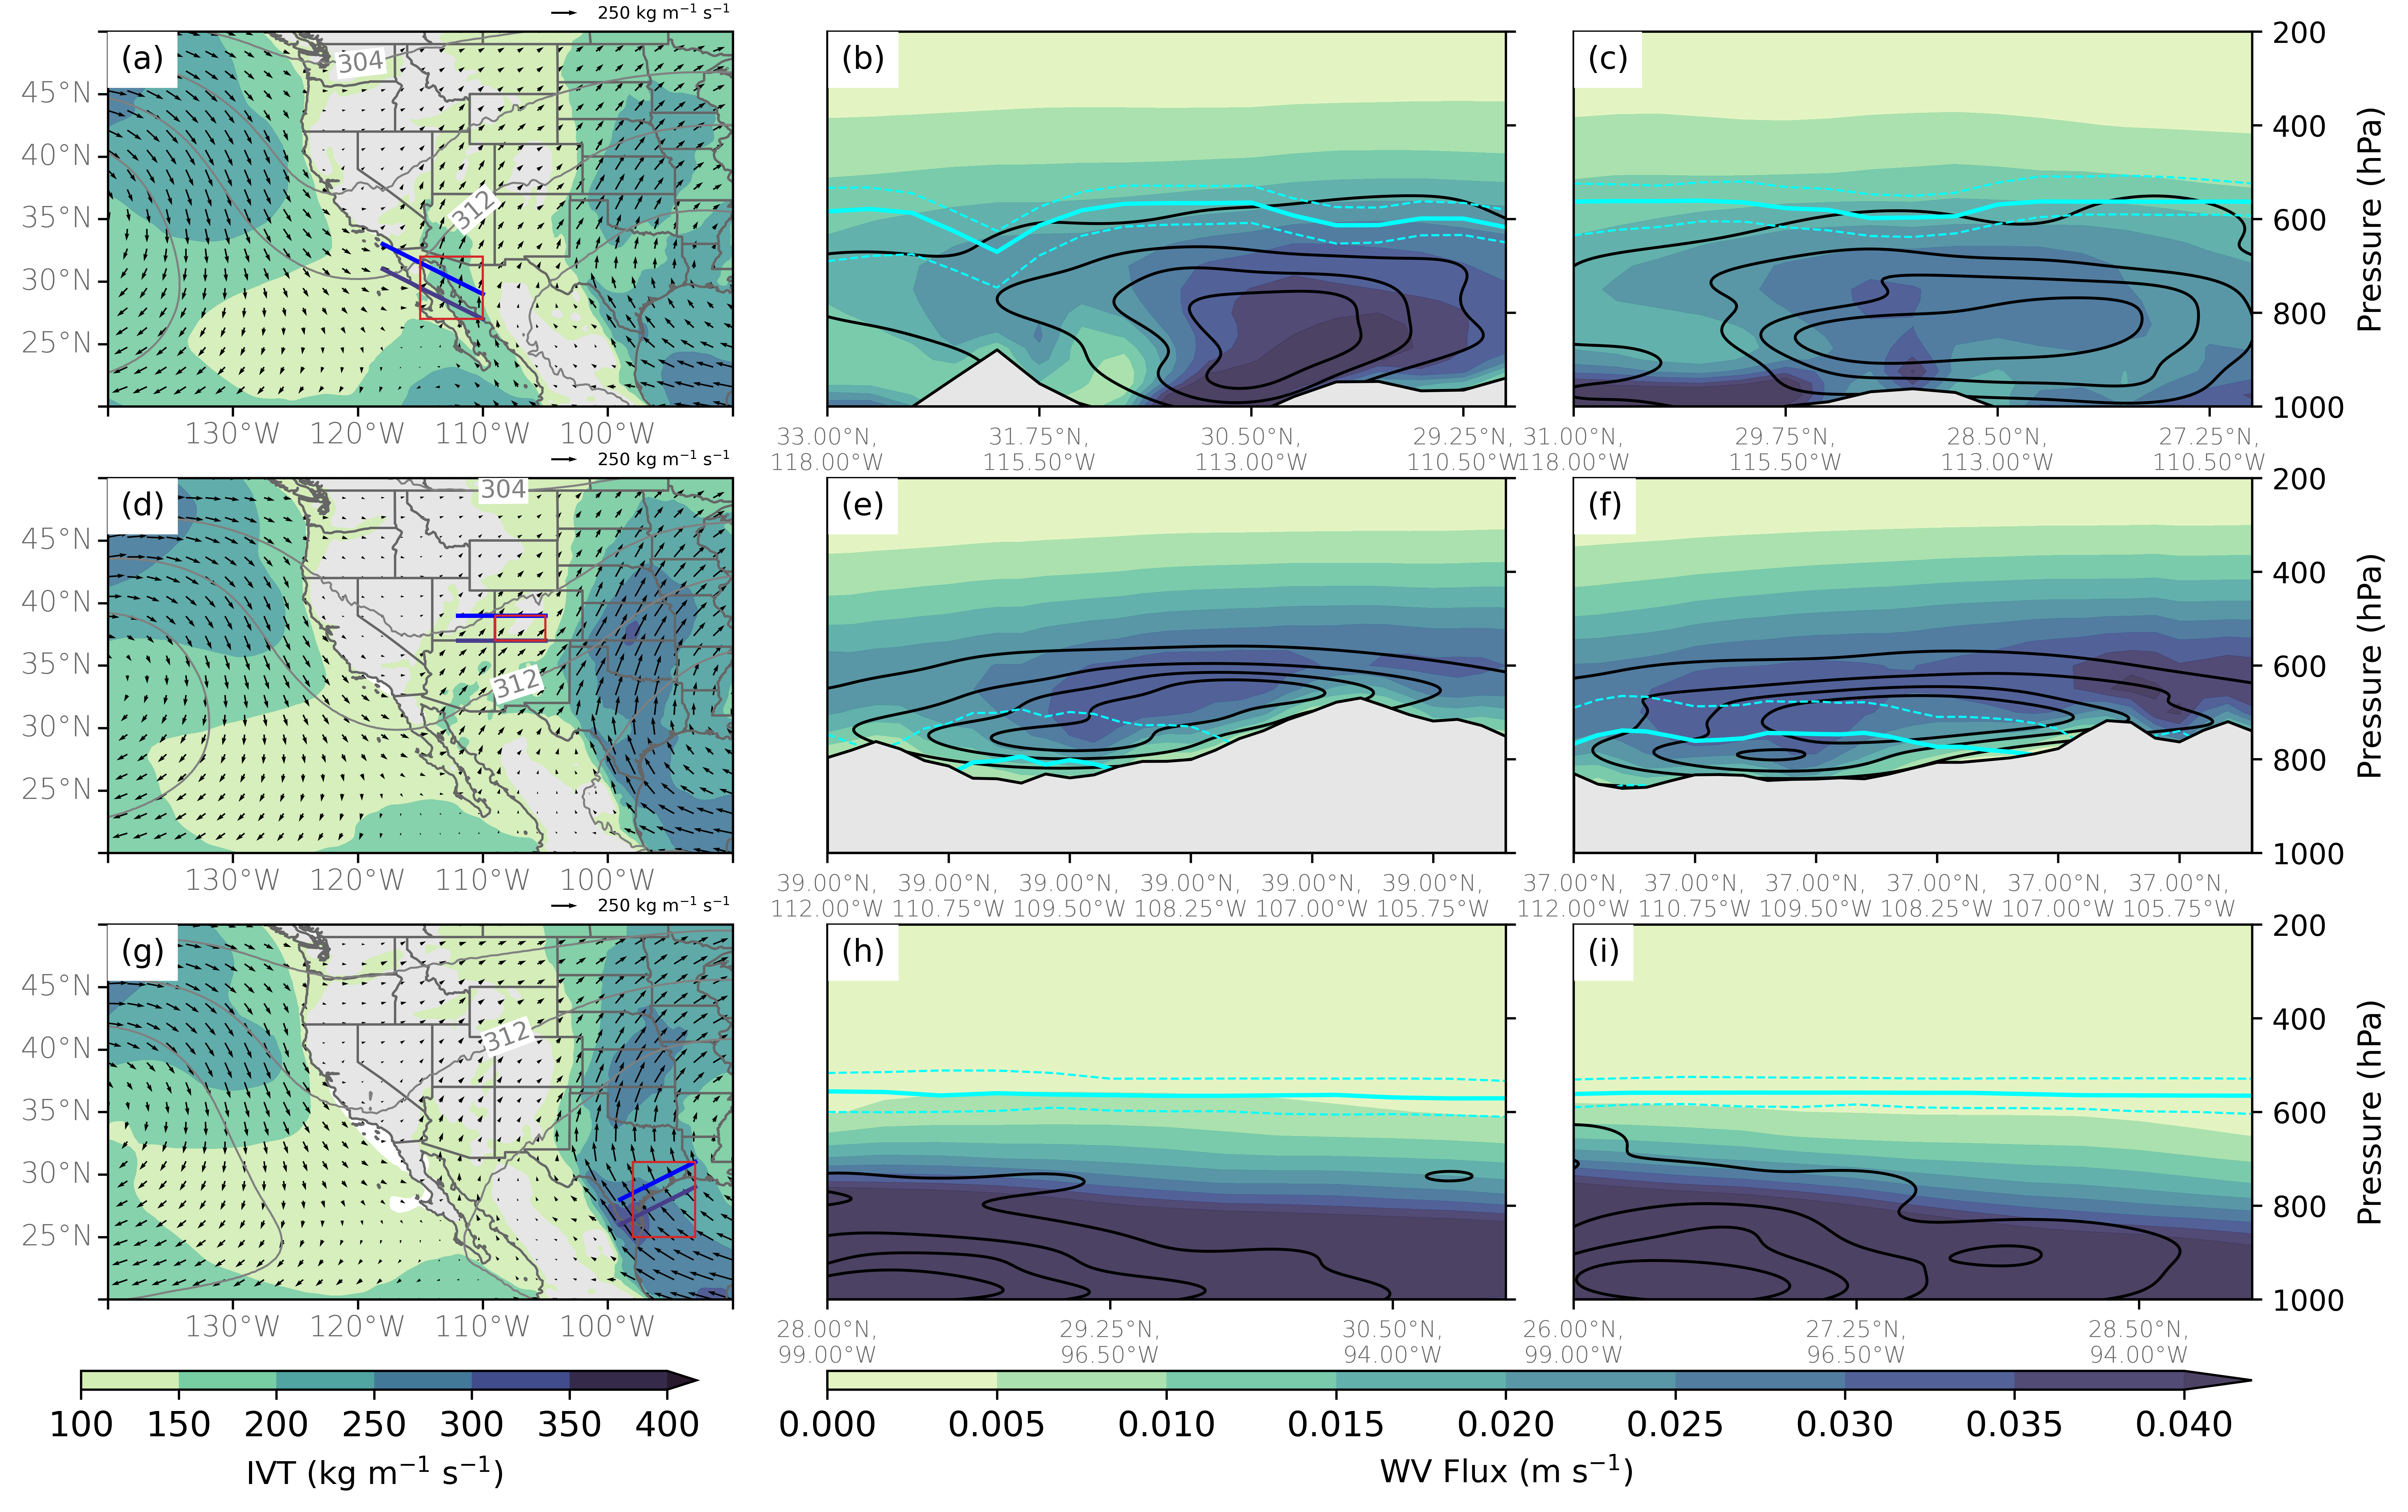

In [8]:
nrows = 4
ncols = 3
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05], width_ratios = [1, 1, 1], wspace=0.1, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(13.5, 8.5))
fig.dpi = 600
ssn = 'MJJASO' ## 'NDJFMA' or 'MJJASO'
fname = path_to_figs + '{0}_composite_trajectory'.format(ssn)
fmt = 'png'

############################
### HORIZONTAL COMPOSITE ###
############################
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in
ext = [-140., -90., 20, 50]
# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

cbax = fig.add_subplot(gs[-1,0]) # colorbar axis
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']
letter_lst = ['a', 'd', 'g']
for i, region in enumerate(region_lst):
    ds3 = ds_hc.sel(ssn=ssn, region=region)
    ax = fig.add_subplot(gs[i, 0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    ax = plot_horizontal_composite(fig, ax, ds3, cbax)
    
    ## add extent of bbox
    ext3 = d[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='tab:red',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))
    clst = ['blue', 'darkslateblue']
    line_lst = [region, region+'2']
    for j, line in enumerate(line_lst):
        ## add cross section line
        ax.plot([d[line]['start_pt'][1], d[line]['end_pt'][1]],
                [d[line]['start_pt'][0], d[line]['end_pt'][0]], color=clst[j],
                transform=ccrs.PlateCarree(), zorder=3)



    titlestring = '({0})'.format(letter_lst[i])
    ax.text(0.02, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)


##############################
### VERTICAL CROSS SECTION ###
##############################
## y-axis is pressure
## x-axis are the points
row_idx = [0, 0, 1, 1, 2, 2]
col_idx = [1, 2, 1, 2, 1, 2]
letter_lst = ['b', 'c', 'e', 'f', 'h', 'i']
for i, (row, col) in enumerate(zip(row_idx, col_idx)):
    ds1 = ds_lst[i]
    ds2 = ds_lst2[i]
    ax = fig.add_subplot(gs[row, col])
    # xs = np.arange(0, len(ds.location), 1) # how many coordinate values
    xs = ds1.longitude.values # latitude / x-axis coords
    ys = ds1.level.values
    # terline = test.values
    terline = ds2.sp.sel(ssn=ssn, quantile=.5).values / 100
    ht_fill = ax.fill_between(xs, 1000, terline, facecolor='0.9', edgecolor='k', zorder=10)
    
    # Filled contours (WV flux)
    cflevs = np.arange(0., 0.045, 0.005)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    data = ds1.wvflux.sel(ssn=ssn)
    cf = ax.contourf(xs, ys, data, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)
    
    ## labels
    plt.gca().invert_yaxis()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylim(1000, 200)
    ax.set_xlim(xs.max(), xs.min())
    if col == 2:
        ax.set_ylabel("Pressure (hPa)", fontsize=11)
    elif col == 1:
        ax.tick_params(labelright=False)
    
    # ## add trajectory point kde
    ## subset dataframe to current season
    start_mon, end_mon = cfunc.get_startmon_and_endmon(ssn)
    df_tmp = select_months_df(df_lst[i], start_mon, end_mon)
    x = df_tmp.lon.values
    y = df_tmp.level.values
    sns.kdeplot(x=x, y=y, levels=5, color="k", linewidths=1)
    
    ## add freezing level
    freeze_line50 = ax.plot(xs, ds2.deg0l.sel(ssn=ssn, quantile=0.5), c='cyan', lw=1.5)
    freeze_line90 = ax.plot(xs, ds2.deg0l.sel(ssn=ssn, quantile=0.9), c='cyan', lw=0.75, linestyle='dashed')
    freeze_line10 = ax.plot(xs, ds2.deg0l.sel(ssn=ssn, quantile=0.1), c='cyan', lw=0.75, linestyle='dashed')
    
    x_ticks = np.arange(len(xs))
    x_labels = [u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(ds1.latitude.values[i], ds1.longitude.values[i]*-1) for i in x_ticks]
    # set the frequency of xtick labels
    skip = 5
    xtick_lbls = [textwrap.fill(label, 8) for label in x_labels[0::skip]]
    ax.set_xticks(xs[0::skip], xtick_lbls, fontsize=6, **kw_ticklabels)

    plt.gca().invert_xaxis()

    titlestring = '({0})'.format(letter_lst[i])
    ax.text(0.02, 0.965, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

# Add color bar
# cbarticks = norm[::1]
cbax = plt.subplot(gs[-1,1:]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('WV Flux (m s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()